# Model Analysis
The objective of this notebook is to develop predictive models to classify melanoma lessions in either benign or malignant. 

To evaluate the performance of each model, Train/Test split (80/20) and Cross-Validation (cv=10) will be used throughout the analysis. The nature of the project requires scoring methods different than accuracy, as mislabelling a benign melanoma is less fatal than mislabelling a malignant. For this reason, the following metrics will be used:
- Confusion Matrix, as a visual verification
- Recall, putting the enphasis on reducing False Negative

Additional metrics, such as AUC, were proposed by the Kaggle organizers. To understand the impact of our decissions, Receiver Operating Characteristic (ROC) curve will be obtained for verification purposes. 

This notebook will have the following sections:
- Data preparation
- Model selection, using three approaches: Metadata Only, Images Only, both sources
- Data optimisation, adding image augmentation techniques to minimise bias
- Model tuning, modifying architecture hyperparameters

# CONFIG

In [1]:
CONFIG = {
    'Learning Rate': 1e-3,
    'Batch Size': 128,
    'Epochs': 10,
    'Patience': 5
}

In [2]:
# !apt-get update ##[edited]
# !apt-get install ffmpeg libsm6 libxext6  -y
# !pip install pandas
# !pip install matplotlib
# !pip install opencv-python
# !pip install albumentations
# !pip install seaborn
# !pip install efficientnet
# !pip install xgboost

## Import Packages

In [3]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

sys.path.append("../Melanoma/")
import data_preprocessing
import image_preprocessing

sys.path.append("../lib/")
import eval_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

print("Tensorflow version " + str(tf.__version__))

Tensorflow version 2.6.0


## Data Preparation

In this section, tabular information is loaded and features are extracted for further postprocessing.

In [5]:
# Go to root if required
if os.getcwd().split("/")[-1] == "Explore":
    os.chdir("..")

# Define datasets locations
# input_dcm_train = 'Datasets/dcm/train/'
# input_dcm_filelist = os.listdir(input_dcm_train)
input_metadata_train = 'Datasets/train.csv'

# Load metadata datasets and remove NA and duplicates
md_train = pd.read_csv(input_metadata_train)                            \
    .pipe(lambda df: df.dropna(subset=["age_approx", "sex"], axis=0))   \
    .pipe(data_preprocessing.AgeOutlierAnalysis)                        \
    .pipe(data_preprocessing.RemoveDuplicateRecords)                    \
    .dropna(axis=0)                                                     \
    .set_index("image_name")                                            \
    .astype({
        "age_approx": 'float',
        "anatom_site_general_challenge": 'category',
        "diagnosis": 'category'
    })

md_train['age_approx'] = MinMaxScaler().fit_transform(md_train['age_approx'].values.reshape(-1,1))
md_train['IsMale'] = md_train.sex.apply(lambda x: 1 if x=="male" else 0)
md_train.head()

,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,IsMale
image_name,,,,,,,,
ISIC_2637011,IP_7279968,male,0.4375,head/neck,unknown,benign,0,1
ISIC_0015719,IP_3075186,female,0.4375,upper extremity,unknown,benign,0,0
ISIC_0052212,IP_2842074,female,0.5000,lower extremity,nevus,benign,0,0
ISIC_0068279,IP_6890425,female,0.4375,head/neck,unknown,benign,0,0
ISIC_0074268,IP_8723313,female,0.5625,upper extremity,unknown,benign,0,0


In [6]:
# Split dataset between features and labels
y = md_train.target
X = md_train.drop(["target", "benign_malignant", "patient_id", "sex", "diagnosis"], axis=1)
X = X.rename({'anatom_site_general_challenge': "Location"}, axis=1)
X = pd.get_dummies(X, columns=["Location"])
X = X.astype('float32')
X.head()

,age_approx,IsMale,Location_head/neck,Location_lower extremity,Location_oral/genital,Location_palms/soles,Location_torso,Location_upper extremity
image_name,,,,,,,,
ISIC_2637011,0.4375,1.0,1.0,0.0,0.0,0.0,0.0,0.0
ISIC_0015719,0.4375,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ISIC_0052212,0.5000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ISIC_0068279,0.4375,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ISIC_0074268,0.5625,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

# Model Training
Now, we will train this dataset with various models:
- KNN
- Random Forest
- XGBoost

The model performance will be measured through Cross-validation using Recall and AUC and plotting both Confussion Matrix.

## Loading models

In [85]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [86]:
DM_model = DummyClassifier(strategy='most_frequent')
KNN_model = KNeighborsClassifier(n_neighbors=5)
RF_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=14)
XGB_model = XGBClassifier(n_estimators=1000, max_depth=10, random_state=14, use_label_encoder=False)

Establish the null score by using the dummy classifier

In [87]:
Null_model = cross_validate(DM_model, X_train, y_train, cv=5, scoring=["roc_auc","recall"])
Null_recall = sum(Null_model['test_recall'])/len(Null_model['test_recall'])
Null_AUC = sum(Null_model['test_roc_auc'])/len(Null_model['test_roc_auc'])

## Standard configuration

In [97]:
# Cross-Validation
cv = StratifiedKFold(n_splits=5)

# KNN Variables
knn_conf_matrix = np.zeros((2,2))
knn_recall = []
knn_auc = []

# Random Forest Variables
rf_conf_matrix = np.zeros((2,2))
rf_recall = []
rf_auc = []

# XGBoost Variables
xg_conf_matrix = np.zeros((2,2))
xg_recall = []
xg_auc = []

for idx_train, idx_test in cv.split(X_train, y_train):
    # Obtain the split
    X_cv, y_cv = X_train.values[idx_train], y_train.values[idx_train]

    # Train both models 
    KNN_model.fit(X_cv, y_cv)
    RF_model.fit(X_cv, y_cv)
    XGB_model.fit(X_cv, y_cv)

    # Obtain prediction dataset
    X_cv, y_cv = X_train.values[idx_test], y_train.values[idx_test]

    # Predict both models
    KNN_pred = KNN_model.predict(X_cv)
    RF_pred = RF_model.predict(X_cv)
    XGB_pred = XGB_model.predict(X_cv)

    # Store Confusion Matrix + Recall Score + AUC
    knn_conf_matrix += confusion_matrix(y_cv, KNN_pred, normalize='true')
    rf_conf_matrix += confusion_matrix(y_cv, RF_pred, normalize='true')
    xg_conf_matrix += confusion_matrix(y_cv, XGB_pred, normalize='true')
    knn_recall.append(recall_score(y_cv, KNN_pred))
    rf_recall.append(recall_score(y_cv, RF_pred))
    xg_recall.append(recall_score(y_cv, XGB_pred))
    knn_auc.append(roc_auc_score(y_cv, KNN_pred))
    rf_auc.append(roc_auc_score(y_cv, RF_pred))
    xg_auc.append(roc_auc_score(y_cv, XGB_pred))

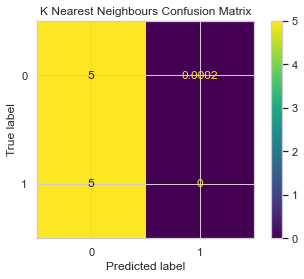

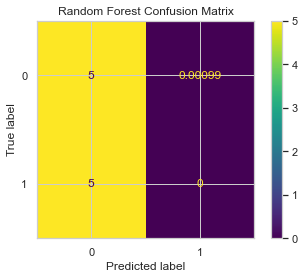

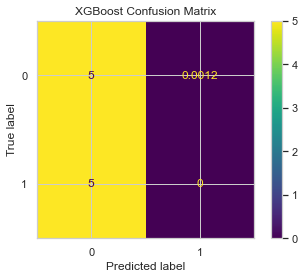

--------------
Recall Results
--------------
Null Hypothesis -> 0.0
KNN           -> 0.0
Random Forest -> 0.0
XGBoost       -> 0.0
--------------

--------------
AUC Results
--------------
Null Hypothesis -> 0.5
KNN           -> 0.4999802097763705
Random Forest -> 0.49990104104724287
XGBoost       -> 0.49988124690630853
--------------


In [90]:
# Analyse the results
# Recall
knn_recall_av = sum(knn_recall)/len(knn_recall)
rf_recall_av = sum(rf_recall)/len(rf_recall)
xg_recall_av = sum(xg_recall)/len(xg_recall)
# AUC 
knn_auc_av = sum(knn_auc)/len(knn_auc)
rf_auc_av = sum(rf_auc)/len(rf_auc)
xg_auc_av = sum(xg_auc)/len(xg_auc)

# Display results
# Confusion Matrix
disp = ConfusionMatrixDisplay(knn_conf_matrix)
disp.plot()
plt.title("K Nearest Neighbours Confusion Matrix")
plt.show()

disp = ConfusionMatrixDisplay(rf_conf_matrix)
disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

disp = ConfusionMatrixDisplay(xg_conf_matrix)
disp.plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

print("--------------")
print("Recall Results")
print("--------------")
print("Null Hypothesis -> " + str(Null_recall))
print("KNN           -> " + str(knn_recall_av))
print("Random Forest -> " + str(rf_recall_av))
print("XGBoost       -> " + str(xg_recall_av))
print("--------------")
print("")
print("--------------")
print("AUC Results")
print("--------------")
print("Null Hypothesis -> " + str(Null_AUC))
print("KNN           -> " + str(knn_auc_av))
print("Random Forest -> " + str(rf_auc_av))
print("XGBoost       -> " + str(xg_auc_av))
print("--------------")


It is clear that these models are highly influenced by the bias in the dataset.
Two alternative approaches will be explored:
- Tune XGBoost hyperparameters
- Try a simple NN

## Tune hyperparameters

Use different combination of hyperparameters to find best model performance

In [91]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

XGB_model = XGBClassifier(random_state=14, verbosity=0, use_label_encoder=False)
params = {
    "n_estimators": [10, 100, 1000],
    "learning_rate": [0.01, 0.1, 0.3, 0.5],
    "max_depth": [5, 10, 20, 50]
}
Grid_CV = GridSearchCV(XGB_model, param_grid=params, scoring='recall', n_jobs=-1, verbose=1)
Grid_CV.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=14,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_label_encoder=Fa

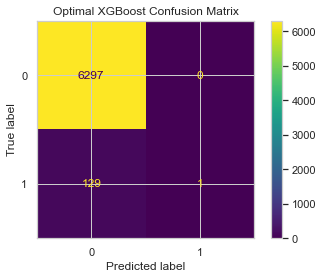

The best parameters found are -> {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}
The best recall achieved are -> 0.0022727272727272726


In [95]:
y_pred = Grid_CV.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Optimal XGBoost Confusion Matrix")
plt.show()


print("The best parameters found are -> " + str(Grid_CV.best_params_))
print("The best recall achieved are -> " + str(Grid_CV.best_score_))


The improvement obtained is marginal, obtaining two classification over the training dataset.
It is clear this is not the way forwards.

## Create simple Neural Network

Create simple 1-hidden stage Neural Network, using two hidden layers with 16 neurons each

In [101]:
num_features = len(X.columns)
num_records = len(X)
dataset = tf.data.Dataset.from_tensor_slices((X, y))

In [102]:
def SplitTrainValTest(ds, ds_size=False, train_split=0.80, val_split=0.2, test_split=0.0, shuffle=False):

    assert (train_split + val_split + test_split) == 1, str(train_split + val_split + test_split)

    if not ds_size:
        ds_size = tf.data.experimental.cardinality(ds).numpy()

    if shuffle:
        ds.shuffle(10000)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [103]:
# Divide datasets into Train (75%), Val (15%), Test (10%)
ds_train, ds_val, ds_test = SplitTrainValTest(dataset)
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_val))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(25704, shape=(), dtype=int64)
tf.Tensor(6426, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)


In [104]:
ds_train = ds_train.batch(CONFIG['Batch Size']).prefetch(1)
ds_val = ds_val.batch(CONFIG['Batch Size']).prefetch(1)
ds_test = ds_test.batch(CONFIG['Batch Size']).prefetch(1)

In [105]:
SimpleNN = Sequential()
SimpleNN.add(Dense(16, activation='relu', input_shape=[num_features]))
SimpleNN.add(Dense(16, activation='relu'))
SimpleNN.add(Dense(1, activation='sigmoid'))
SimpleNN.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_19 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 17        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [106]:
SimpleNN.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['AUC'])
SimpleNN.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=EarlyStopping(monitor='val_auc', patience=5))

Epoch 1/100
201/201 [==============================] - 1s 2ms/step - loss: 0.2221 - auc: 0.4937 - val_loss: 0.1250 - val_auc: 0.4673
Epoch 2/100
201/201 [==============================] - 0s 919us/step - loss: 0.1112 - auc: 0.4962 - val_loss: 0.1025 - val_auc: 0.4849
Epoch 3/100
201/201 [==============================] - 0s 903us/step - loss: 0.1012 - auc: 0.4968 - val_loss: 0.0981 - val_auc: 0.4672
Epoch 4/100
201/201 [==============================] - 0s 903us/step - loss: 0.0987 - auc: 0.4896 - val_loss: 0.0964 - val_auc: 0.4706
Epoch 5/100
201/201 [==============================] - 0s 920us/step - loss: 0.0975 - auc: 0.4901 - val_loss: 0.0952 - val_auc: 0.4700
Epoch 6/100
201/201 [==============================] - 0s 917us/step - loss: 0.0967 - auc: 0.4932 - val_loss: 0.0943 - val_auc: 0.4727
Epoch 7/100
201/201 [==============================] - 0s 922us/step - loss: 0.0960 - auc: 0.4988 - val_loss: 0.0936 - val_auc: 0.4898
Epoch 8/100
201/201 [==============================] - 0s

--------- Standard Threshold -------
------------------------------------
Validation AUC    --> 0.47111054046921036
Validation Recall --> 0.0
------------------------------------
Best Threshold=0.020566, G-Mean=0.525

--------- Optimal Threshold --------
------------------------------------
Validation AUC    --> 0.47111054046921036
Validation Recall --> 0.40540540540540543
------------------------------------


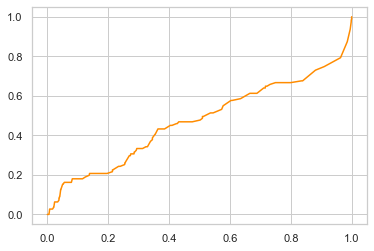

<Figure size 432x288 with 0 Axes>

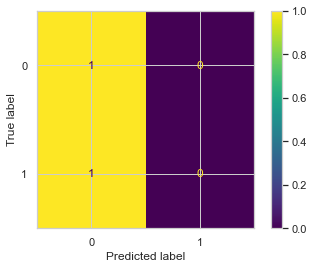

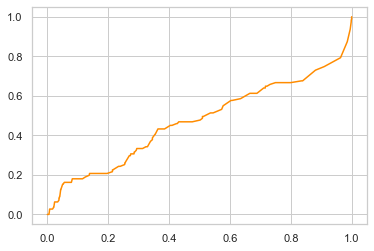

<Figure size 432x288 with 0 Axes>

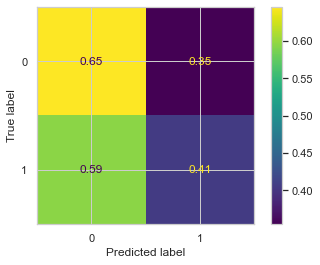

In [107]:
pred, labels = eval_model.Obtain_Prediction_Labels(SimpleNN, ds_val)
print("--------- Standard Threshold -------")
eval_model.Evaluate_NN(pred, labels)
thres = eval_model.OptimizeThreshold(pred, labels)
print()
print("--------- Optimal Threshold --------")
eval_model.Evaluate_NN(pred, labels, threshold=thres)

The bias on this model towards the minority class is even higher. Next step - Try including *class_weight*

In [108]:
SimpleNN = Sequential()
SimpleNN.add(Dense(16, activation='relu', input_shape=[num_features]))
SimpleNN.add(Dense(16, activation='relu'))
SimpleNN.add(Dense(1, activation='sigmoid'))

In [109]:
SimpleNN.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['AUC'])
SimpleNN.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=EarlyStopping(monitor='val_auc', patience=5), class_weight = {0: 1., 1: 80.})

Epoch 1/100
201/201 [==============================] - 1s 2ms/step - loss: 1.6199 - auc: 0.5672 - val_loss: 0.9375 - val_auc: 0.6485
Epoch 2/100
201/201 [==============================] - 0s 953us/step - loss: 1.5958 - auc: 0.6191 - val_loss: 0.9517 - val_auc: 0.6624
Epoch 3/100
201/201 [==============================] - 0s 957us/step - loss: 1.5814 - auc: 0.6314 - val_loss: 0.9557 - val_auc: 0.6670
Epoch 4/100
201/201 [==============================] - 0s 947us/step - loss: 1.5701 - auc: 0.6377 - val_loss: 0.9583 - val_auc: 0.6712
Epoch 5/100
201/201 [==============================] - 0s 937us/step - loss: 1.5605 - auc: 0.6437 - val_loss: 0.9583 - val_auc: 0.6767
Epoch 6/100
201/201 [==============================] - 0s 955us/step - loss: 1.5521 - auc: 0.6494 - val_loss: 0.9567 - val_auc: 0.6799


--------- Standard Threshold -------
------------------------------------
Validation AUC    --> 0.6803035814912299
Validation Recall --> 0.918918918918919
------------------------------------
Best Threshold=0.672078, G-Mean=0.648
--------- Optimal Threshold --------
------------------------------------
Validation AUC    --> 0.6803035814912299
Validation Recall --> 0.5495495495495496
------------------------------------


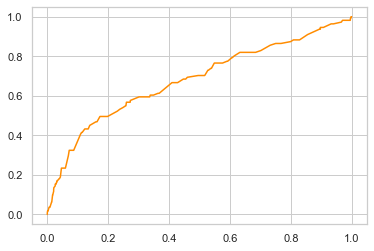

<Figure size 432x288 with 0 Axes>

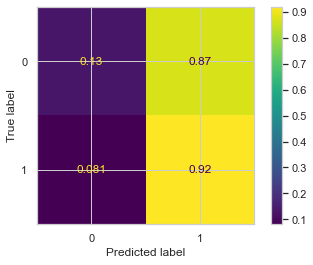

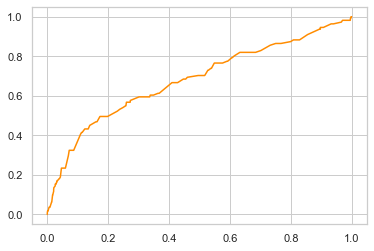

<Figure size 432x288 with 0 Axes>

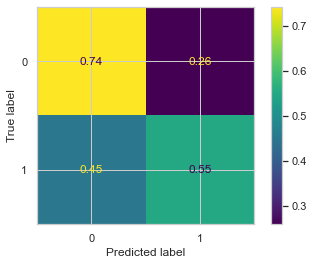

In [110]:
pred, labels = eval_model.Obtain_Prediction_Labels(SimpleNN, ds_val)
print("--------- Standard Threshold -------")
eval_model.Evaluate_NN(pred, labels)
thres = eval_model.OptimizeThreshold(pred, labels)
print("--------- Optimal Threshold --------")
eval_model.Evaluate_NN(pred, labels, threshold=thres)

# CNN Models on Melanoma images

This section focuses on the development of an input pipeline for images to be read from the dataset and train the different models.

In [7]:
# Remove duplicated records based on previous analysis
# Need to run first data_preprocessing.RemoveDuplicateRecords
def RemoveDuplicatedImagesFromFolder(path, label_dict):
    files = os.listdir(path)
    valid_files = label_dict.index

    for file in files:
        if os.path.isfile(path + os.sep + file):
            if file.split('.')[0] in valid_files:
                pass
            else:
                os.remove(path + file)

# Create structure for TensorFlow to process the images
def CreateFolderStructTF(path, label_dict):
    # Create the directories if required
    try:
        os.makedirs(path + os.sep + 'Benign', exist_ok=False)
    except:
        pass

    try:
        os.makedirs(path + os.sep + 'Malignant', exist_ok=False)
    except:
        pass

    for file in label_dict.index.to_list():
        filename = path + os.sep + file + '.jpg'
        if os.path.isfile(filename):
            if label_dict.loc[file]==1:
                os.replace(filename, path + os.sep + 'Malignant' + os.sep + file + '.jpg')
            else:
                os.replace(filename, path + os.sep + 'Benign' + os.sep + file + '.jpg')
            
     

In [8]:
# Establish default parameters
input_jpeg_train = 'Datasets/jpeg/train_256'
img_label_df = md_train.target.sort_index()
image_height = 256
image_width = 256
image_channels = 3

# Remove duplicated images - if any
RemoveDuplicatedImagesFromFolder(input_jpeg_train, img_label_df)

# Create folder structure as requested by TF -> https://stackoverflow.com/questions/68449103/tf-keras-preprocessing-image-dataset-from-directory-value-error-no-images-found
CreateFolderStructTF(input_jpeg_train, img_label_df)

# Obtain training dataset
img_train_ds = tf.keras.utils.image_dataset_from_directory(
  input_jpeg_train,
  labels="inferred",
  # labels=img_label_df.to_list(),
  validation_split=0.2,
  subset="training",
  seed=14,
  label_mode='binary',
  image_size=(image_height,image_width),
  batch_size=CONFIG['Batch Size'])

# Obtain validation dataset
img_val_ds = tf.keras.utils.image_dataset_from_directory(
  input_jpeg_train,
  labels="inferred",
  # labels=img_label_df.to_list(),
  validation_split=0.2,
  subset="validation",
  seed=14,
  label_mode='binary',
  image_size=(image_height,image_width),
  batch_size=CONFIG['Batch Size'])

Found 32131 files belonging to 2 classes.
Using 25705 files for training.


2021-11-12 14:28:20.266577: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 32131 files belonging to 2 classes.
Using 6426 files for validation.


In [9]:
# Check that the classes are OK
class_names = img_train_ds.class_names
print(class_names)
for image_batch, labels_batch in img_train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['Benign', 'Malignant']


2021-11-12 14:28:22.186508: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(128, 256, 256, 3)
(128, 1)


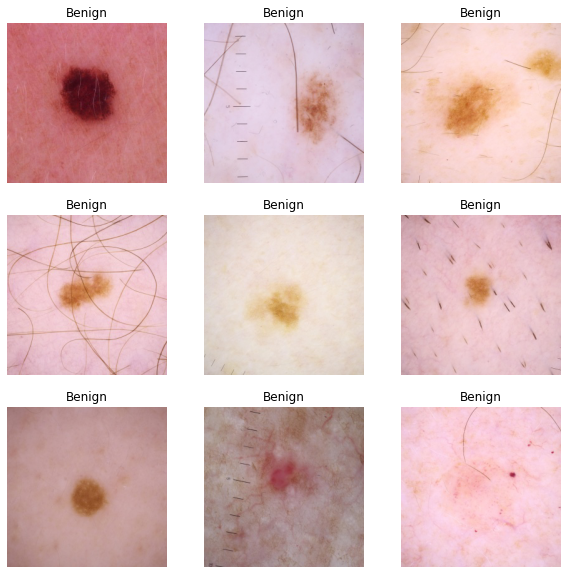

In [10]:
import matplotlib.pyplot as plt

# Plot some example images
plt.figure(figsize=(10, 10))
for images, labels in img_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

In [11]:
# Prefetch data for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = img_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = img_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Learning rate schedule: 5e-06 to 0.001 to 0.000188


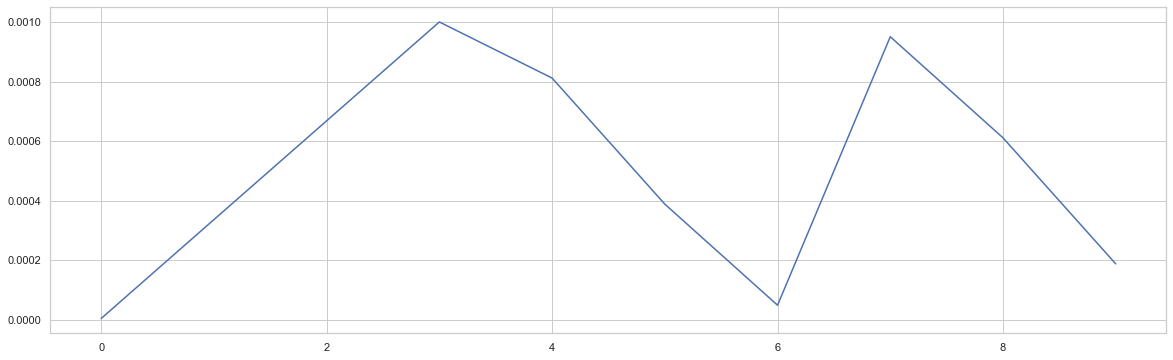

In [12]:
import math
import seaborn as sns

def cosine_with_hard_restarts_schedule_with_warmup(epoch):
    """ Create a schedule with a learning rate that decreases following the
    values of the cosine function with several hard restarts, after a warmup
    period during which it increases linearly between 0 and 1.
    """
    lr_start   = 5e-6
    lr_max     = CONFIG['Learning Rate']
    lr_min     = 1e-6
    warmup_epochs = 3
    num_cycles = 9.
    total_epochs = CONFIG['Epochs']
    
    # During warm-up - Linear increase
    if epoch < warmup_epochs:
        lr = (lr_max - lr_start) / warmup_epochs * epoch + lr_start

    # After warm-up - Cosine Annealing
    else:
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        lr = lr_max * (0.5 * (1.0 + tf.math.cos(math.pi * ((num_cycles * progress) % 1.0))))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

def get_lr_callback():
    lr_callback = tf.keras.callbacks.LearningRateScheduler(cosine_with_hard_restarts_schedule_with_warmup, verbose=False)
    return lr_callback

# Plot to demonstrate it works
total_epochs = CONFIG['Epochs']
rng = [i for i in range(0, total_epochs)]
y = [cosine_with_hard_restarts_schedule_with_warmup(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Simple CNN model

In [23]:
from keras.models import Sequential
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense

tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

CNN_custom_model = Sequential([
  Rescaling(1./255., input_shape=(image_height, image_width, 3)),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(16, activation='relu'),
  Dense(1, activation='sigmoid')
])
CNN_custom_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0

In [24]:
# Define optimizers and compile
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
CNN_custom_model.compile(optimizer=opt, loss=loss, metrics=['AUC'])

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Callbacks - Early Stopping + Save best
es = EarlyStopping(monitor='val_auc', mode='max', patience=CONFIG['Patience'], verbose=1)
checkpoint_auc = ModelCheckpoint('Models/BasicCNN_BestAUC.h5', monitor='val_auc', mode='max', save_best_only=True,
                                    save_weights_only=True, verbose=0)

In [26]:
# Fit the model
history = CNN_custom_model.fit(img_train_ds, 
                        validation_data=img_val_ds, 
                        callbacks=[es, checkpoint_auc, get_lr_callback()], 
                        epochs=CONFIG['Epochs'], 
                        verbose=1).history
                    

Epoch 1/10
 13/201 [>.............................] - ETA: 12:25 - loss: 0.7448 - auc: 0.4547

KeyboardInterrupt: 

In [ ]:
pred, labels = eval_model.Obtain_Prediction_Labels(CNN_custom_model, img_val_ds)
print("--------- Standard Threshold -------")
eval_model.Evaluate_NN(pred, labels)
thres = eval_model.OptimizeThreshold(pred, labels)
print("--------- Optimal Threshold --------")
eval_model.Evaluate_NN(pred, labels, threshold=thres)

## Data Augmentation

In this section, I explore the possibilities of data augmentation on our data

In [ ]:
from keras.layers import RandomFlip, RandomRotation, RandomZoom

DataAugm_layer = keras.Sequential(
  [
    RandomFlip("horizontal",
                      input_shape=(image_height,
                                  image_width,
                                  3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

In [ ]:
from keras.layers import Dropout, Rescaling, Conv2D, MaxPooling2D, Dense, Flatten

DataAug_Model = Sequential([
  DataAugm_layer,
  Rescaling(1./255),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(1, activation='sigmoid')
])
DataAug_Model.summary()

In [ ]:
# Define optimizers and compile
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
DataAug_Model.compile(optimizer=opt, loss=loss, metrics=['AUC'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Callbacks - Early Stopping + Save best
es = EarlyStopping(monitor='val_auc', mode='max', patience=CONFIG['Patience'], verbose=1)
checkpoint_auc = ModelCheckpoint('Models/ImgAug_BestAUC.h5', monitor='val_auc', mode='max', save_best_only=True,
                                    save_weights_only=True, verbose=0)

In [ ]:
# Fit the model
history = DataAug_Model.fit(img_train_ds, 
                        validation_data=img_val_ds, 
                        callbacks=[es, checkpoint_auc, get_lr_callback()], 
                        epochs=CONFIG['Epochs'], 
                        verbose=1).history

In [ ]:
pred, labels = eval_model.Obtain_Prediction_Labels(DataAug_Model, img_val_ds)
print("--------- Standard Threshold -------")
eval_model.Evaluate_NN(pred, labels)
thres = eval_model.OptimizeThreshold(pred, labels)
print("--------- Optimal Threshold --------")
eval_model.Evaluate_NN(pred, labels, threshold=thres)

Unfortunately, Data Augmentation on its own didn't help in this context - as the model is too simple to learn the Melanoma features.

## Transfer Learning

Using now the famous EfficientNetB2 model using cosine anneling learning rate

In [ ]:
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras import losses
from keras.models import Model
from efficientnet.tfkeras import EfficientNetB2

# Define input characteristics
input_shape = (image_height, image_width, 3)

# Define input into EfficientNetB5
input_image = Input(shape=input_shape, name='input_image')
rescale_image = Rescaling(1./255, input_shape=(image_height, image_width, 3))(input_image)

# Load EfficientNet
EfficientNet_model = EfficientNetB2(input_shape=input_shape, 
                                weights='noisy-student',
                                include_top=False)
# Define our side
x = EfficientNet_model(rescale_image)
x = GlobalAveragePooling2D()(x)
# dense_1 = Dense(16, activation='relu')(x)
output = Dense(1, activation='sigmoid', name='output')(x)

# Define the different inputs
EFN_model = Model(inputs=input_image, outputs=output)
print(EFN_model.summary())

# Define optimizers and compile
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = losses.BinaryCrossentropy(label_smoothing=0.05)
EFN_model.compile(optimizer=opt, loss=loss, metrics=['AUC'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Callbacks - Early Stopping + Save best
es = EarlyStopping(monitor='val_auc', mode='max', patience=CONFIG['Patience'], verbose=1)
checkpoint_auc = ModelCheckpoint('Models/EFN_BestAUC.h5', monitor='val_auc', mode='max', save_best_only=True,
                                    save_weights_only=True, verbose=0)

In [ ]:
EFN_model.layers[2].trainable = False
EFN_model.summary()

In [ ]:
# Fit the model
history = EFN_model.fit(img_train_ds, 
                        validation_data=img_val_ds, 
                        callbacks=[es, checkpoint_auc, get_lr_callback()], 
                        epochs=CONFIG['Epochs'], 
                        verbose=1).history

In [ ]:
pred, labels = eval_model.Obtain_Prediction_Labels(EFN_model, img_val_ds)
print("--------- Standard Threshold -------")
eval_model.Evaluate_NN(pred, labels)
thres = eval_model.OptimizeThreshold(pred, labels)
print("--------- Optimal Threshold --------")
eval_model.Evaluate_NN(pred, labels, threshold=thres)

## Load Previously Stored model

In [ ]:
from keras.models import Sequential
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Input, GlobalAveragePooling2D
from keras import losses
from keras.models import Model
from efficientnet.tfkeras import EfficientNetB2


# Define input characteristics
input_shape = (image_height, image_width, 3)

# Define input into EfficientNetB5
input_image = Input(shape=input_shape, name='input_image')
rescale_image = Rescaling(1./255, input_shape=(image_height, image_width, 3))(input_image)

# Load EfficientNet
EfficientNet_model = EfficientNetB2(input_shape=input_shape, 
                                weights='noisy-student',
                                include_top=False)
# Define our side
x = EfficientNet_model(rescale_image)
x = GlobalAveragePooling2D()(x)
# dense_1 = Dense(16, activation='relu')(x)
output = Dense(1, activation='sigmoid', name='output')(x)

# Define the different inputs
EFN_model_load = Model(inputs=input_image, outputs=output)
print(EFN_model_load.summary())

# Define optimizers and compile
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = losses.BinaryCrossentropy(label_smoothing=0.05)
EFN_model_load.compile(optimizer=opt, loss=loss, metrics=['AUC'])

EFN_model_load.load_weights("Models/EFN_BestAUC.h5")

In [ ]:
pred, labels = eval_model.Obtain_Prediction_Labels(EFN_model_load, img_val_ds)
print("--------- Standard Threshold -------")
eval_model.Evaluate_NN(pred, labels)
thres = eval_model.OptimizeThreshold(pred, labels)
print("--------- Optimal Threshold --------")
eval_model.Evaluate_NN(pred, labels, threshold=thres)

## Putting everything together

Now we will use all techniques together to further enhance the performance. 

In [13]:
from keras.layers import RandomFlip, RandomRotation, RandomZoom

DataAugm_layer = keras.Sequential(
  [
    RandomFlip("horizontal",
                      input_shape=(image_height,
                                  image_width,
                                  3)),
    RandomFlip("vertical"),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

In [23]:
from keras.layers import Input, GlobalAveragePooling2D, Dense, Rescaling
from keras import losses
from keras.models import Model
from efficientnet.tfkeras import EfficientNetB2

# Define input characteristics
input_shape = (image_height, image_width, 3)

# Define final model
EFN_ImgAug_model = Sequential([
    Input(shape=input_shape, name='input_image'),
    DataAugm_layer,
    Rescaling(1./255),
    EfficientNetB2(input_shape=input_shape, 
                                weights='noisy-student',
                                include_top=False),
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid', name='output')
    ])

# Ensure efficientNet is not retrained
EFN_ImgAug_model.layers[2].trainable = False
print(EFN_ImgAug_model.summary())

# Define optimizers and compile
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = losses.BinaryCrossentropy(label_smoothing=0.05)
EFN_ImgAug_model.compile(optimizer=opt, loss=loss, metrics=['AUC'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
efficientnet-b2 (Functional) (None, 8, 8, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1408)              0         
_________________________________________________________________
output (Dense)               (None, 1)                 1409      
Total params: 7,769,971
Trainable params: 1,409
Non-trainable params: 7,768,562
_________________________________________________________________
None


In [21]:
EFN_ImgAug_model.layers[2].trainable = True
print(EFN_ImgAug_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
efficientnet-b2 (Functional) (None, 8, 8, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
output (Dense)               (None, 1)                 1409      
Total params: 7,769,971
Trainable params: 7,702,403
Non-trainable params: 67,568
_________________________________________________________________
None


In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Callbacks - Early Stopping + Save best
es = EarlyStopping(monitor='val_auc', mode='max', patience=CONFIG['Patience'], verbose=1)
checkpoint_auc = ModelCheckpoint('Models/EFN_ImgAug_BestAUC.h5', monitor='val_auc', mode='max', save_best_only=True,
                                    save_weights_only=True, verbose=0)

In [22]:
# Fit the model
history = EFN_ImgAug_model.fit(img_train_ds, 
                        validation_data=img_val_ds, 
                        callbacks=[es, checkpoint_auc, get_lr_callback()], 
                        epochs=CONFIG['Epochs'], 
                        verbose=1).history

Epoch 1/10
201/201 [==============================] - 1148s 6s/step - loss: 0.1668 - auc: 0.8463 - val_loss: 0.1683 - val_auc: 0.7852
Epoch 2/10
201/201 [==============================] - 1130s 6s/step - loss: 0.1672 - auc: 0.8439 - val_loss: 0.1682 - val_auc: 0.7903
Epoch 3/10
201/201 [==============================] - 1080s 5s/step - loss: 0.1670 - auc: 0.8405 - val_loss: 0.1681 - val_auc: 0.7896
Epoch 4/10
201/201 [==============================] - 1084s 5s/step - loss: 0.1671 - auc: 0.8356 - val_loss: 0.1680 - val_auc: 0.7932
Epoch 5/10
201/201 [==============================] - 1083s 5s/step - loss: 0.1669 - auc: 0.8417 - val_loss: 0.1680 - val_auc: 0.7912
Epoch 6/10
201/201 [==============================] - 1085s 5s/step - loss: 0.1667 - auc: 0.8433 - val_loss: 0.1679 - val_auc: 0.7929
Epoch 7/10
201/201 [==============================] - 1085s 5s/step - loss: 0.1659 - auc: 0.8620 - val_loss: 0.1683 - val_auc: 0.7900
Epoch 8/10
201/201 [==============================] - 1172s 6s

--------- Standard Threshold -------
------------------------------------
Validation AUC    --> 0.7548579458318175
Validation Recall --> 0.0
------------------------------------
Best Threshold=0.046907, G-Mean=0.709
--------- Optimal Threshold --------
------------------------------------
Validation AUC    --> 0.7548579458318175
Validation Recall --> 0.6576576576576577
------------------------------------


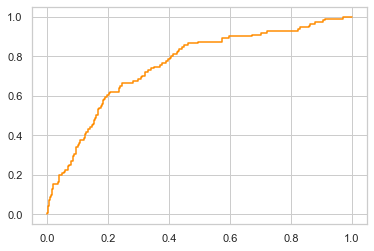

<Figure size 432x288 with 0 Axes>

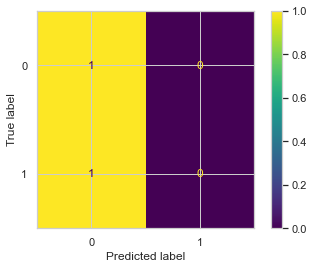

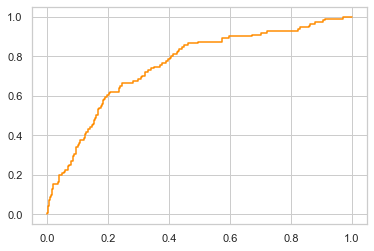

<Figure size 432x288 with 0 Axes>

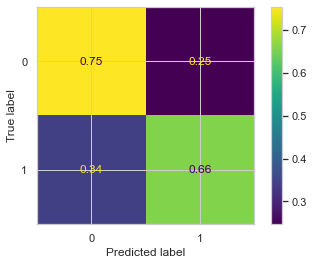

In [18]:
pred, labels = eval_model.Obtain_Prediction_Labels(EFN_ImgAug_model, img_val_ds)
print("--------- Standard Threshold -------")
eval_model.Evaluate_NN(pred, labels)
thres = eval_model.OptimizeThreshold(pred, labels)
print("--------- Optimal Threshold --------")
eval_model.Evaluate_NN(pred, labels, threshold=thres)